## Specific Enhancement

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import unittest

In [9]:
def classic_enhance(img, upscale_factor=2, gamma=1.0):
    """
    Classic image processing enhancement using histogram equalization, 
    sharpening, morphological filtering, and gamma correction.
    """
    # 1. Upscale for HD (bicubic)
    h, w = img.shape[:2]
    img_up = cv2.resize(img, (w * upscale_factor, h * upscale_factor),
                        interpolation=cv2.INTER_CUBIC)
    
    # 2. Convert to YUV (or use grayscale for luminance)
    img_yuv = cv2.cvtColor(img_up, cv2.COLOR_RGB2YUV)
    y, u, v = cv2.split(img_yuv)
    
    # 3. Histogram equalization on Y channel (luminance)
    y_eq = cv2.equalizeHist(y)
    
    # Optionally, you might use CLAHE instead:
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    # y_eq = clahe.apply(y)
    
    # 4. Contrast stretching / normalization on Y
    # (linearly stretch to full [0,255] range)
    y_min, y_max = np.min(y_eq), np.max(y_eq)
    y_stretch = ((y_eq - y_min) / (y_max - y_min) * 255).astype(np.uint8)
    
    # Reassemble YUV with adjusted luminance
    img_yuv2 = cv2.merge([y_stretch, u, v])
    img_corr = cv2.cvtColor(img_yuv2, cv2.COLOR_YUV2RGB)
    
    # 5. Sharpening via unsharp mask or high-pass + add back
    # Create a blurred version
    blurred = cv2.GaussianBlur(img_corr, (3,3), 0)
    # Unsharp mask: original + amount * (original - blurred)
    amount = 1.0
    sharpened = cv2.addWeighted(img_corr, 1 + amount, blurred, -amount, 0)
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    
    # 6. Denoising (if needed) - use a mild smoothing to suppress noise
    denoised = cv2.fastNlMeansDenoisingColored(sharpened, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
    
    # 7. Morphological operations on luminance mask or edges
    # Optionally detect edges and refine:
    gray = cv2.cvtColor(denoised, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3,3), np.uint8)
    mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask_close = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel)
    # You can use mask to selectively smooth or sharpen regions
    
    # 8. (Optional) Blend the sharpened image and the color-corrected base
    # E.g., keep colors from img_corr and details from denoised
    alpha = 0.7
    blended = cv2.addWeighted(denoised, alpha, img_corr, 1 - alpha, 0)
    
    # 9. Apply gamma correction to the result
    if gamma != 1.0:
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
        final = cv2.LUT(blended, table)
    else:
        final = blended
    
    return final

In [17]:
class TestClassicEnhance(unittest.TestCase):

    def setUp(self):
        # Create a dummy RGB test image (simple gradient pattern)
        self.img = np.zeros((50, 50, 3), dtype=np.uint8)
        for i in range(50):
            for j in range(50):
                self.img[i, j] = [i * 5 % 255, j * 5 % 255, (i + j) * 3 % 255]

    def test_output_shape(self):
        upscale_factor = 2
        enhanced = classic_enhance(self.img, upscale_factor=upscale_factor)
        expected_shape = (self.img.shape[0] * upscale_factor,
                          self.img.shape[1] * upscale_factor,
                          3)
        self.assertEqual(enhanced.shape, expected_shape,
                         "Output shape should match upscaled dimensions.")

    def test_output_dtype(self):
        enhanced = classic_enhance(self.img)
        self.assertEqual(enhanced.dtype, np.uint8,
                         "Output dtype should be uint8.")

    def test_output_value_range(self):
        enhanced = classic_enhance(self.img)
        self.assertTrue(np.all(enhanced >= 0) and np.all(enhanced <= 255),
                        "All pixel values should be within [0, 255].")

    def test_gamma_effect(self):
        img_default = classic_enhance(self.img, gamma=1.0)
        img_gamma = classic_enhance(self.img, gamma=1.5)
        diff = np.mean(cv2.absdiff(img_default, img_gamma))
        self.assertGreater(diff, 0,
                           "Changing gamma should produce a visibly different image.")

    def test_image_difference(self):
        enhanced = classic_enhance(self.img)
        resized_back = cv2.resize(enhanced, (50, 50))
        diff = np.mean(cv2.absdiff(self.img, resized_back))
        self.assertGreater(diff, 0,
                           "Enhanced image should not be identical to the original.")

# Run tests directly inside notebook
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestClassicEnhance))

.....
----------------------------------------------------------------------
Ran 5 tests in 0.498s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

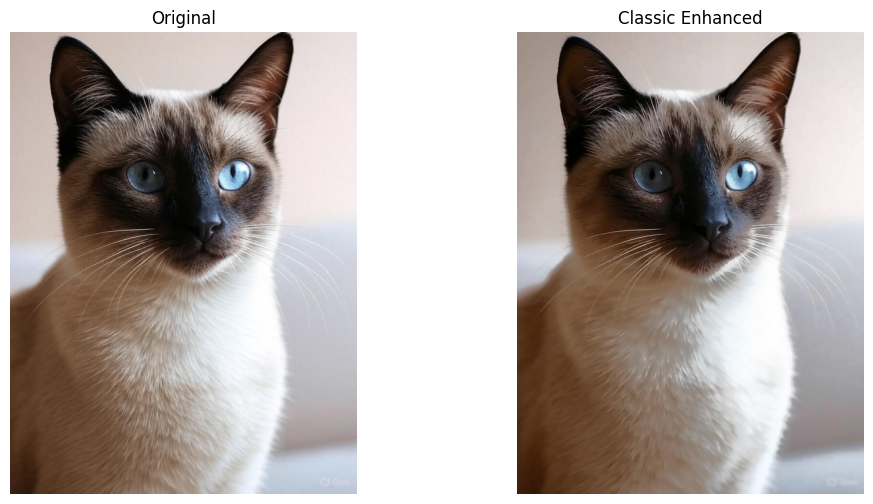

In [10]:
# --- Use it on your image ---
img_path = "assets/Image.jpeg"
img0 = cv2.imread(img_path)
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

enh = classic_enhance(img0, upscale_factor=2, gamma=1.2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img0)
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Classic Enhanced")
plt.imshow(enh)
plt.axis('off')
plt.show()

## General Enhancement

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def general_enhance(img, upscale_factor=2):
    """
    Classic image processing enhancement using histogram equalization,
    sharpening, morphological filtering, and gamma correction, but for more general image for robust image processing.
    """
    
    # Step 1: Upscale for HD enhancement
    img_up = cv2.resize(img, (img.shape[1]*upscale_factor, img.shape[0]*upscale_factor), interpolation=cv2.INTER_CUBIC)

    # Step 2: Convert to LAB for global brightness/contrast normalization
    lab = cv2.cvtColor(img_up, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    img_eq = cv2.merge((l, a, b))
    img_eq = cv2.cvtColor(img_eq, cv2.COLOR_LAB2RGB)

    # Step 3: Auto gamma correction based on image brightness
    gray = cv2.cvtColor(img_eq, cv2.COLOR_RGB2GRAY)
    mean_brightness = np.mean(gray) / 255.0
    gamma = 1.0 + (0.5 - mean_brightness)  # Dynamic gamma
    gamma = np.clip(gamma, 0.5, 1.5)
    gamma_corrected = np.power(img_eq / 255.0, gamma)
    gamma_corrected = np.clip(gamma_corrected * 255, 0, 255).astype(np.uint8)

    # Step 4: Sharpen with adaptive strength
    sharp_kernel = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    sharpened = cv2.filter2D(gamma_corrected, -1, sharp_kernel)

    # Step 5: Slight blur for denoising
    blurred = cv2.GaussianBlur(sharpened, (3,3), 0)

    # Step 6: Morphological refinement
    kernel = np.ones((3,3), np.uint8)
    opened = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    # Step 7: Combine sharpened & refined layers
    final = cv2.addWeighted(closed, 1.1, sharpened, -0.1, 0)

    return final


In [ ]:
class TestGeneralEnhance(unittest.TestCase):

    def setUp(self):
        self.img = np.zeros((50, 50, 3), dtype=np.uint8)
        for i in range(50):
            for j in range(50):
                self.img[i, j] = [i * 5 % 255, j * 5 % 255, (i + j) * 3 % 255]

    def test_output_shape(self):
        upscale_factor = 2
        enhanced = general_enhance(self.img, upscale_factor=upscale_factor)
        expected_shape = (self.img.shape[0] * upscale_factor,
                          self.img.shape[1] * upscale_factor,
                          3)
        self.assertEqual(enhanced.shape, expected_shape)

    def test_output_dtype(self):
        enhanced = general_enhance(self.img)
        self.assertEqual(enhanced.dtype, np.uint8)

    def test_output_value_range(self):
        enhanced = general_enhance(self.img)
        self.assertTrue(np.all(enhanced >= 0) and np.all(enhanced <= 255))

    def test_image_difference(self):
        enhanced = general_enhance(self.img)
        diff = np.mean(cv2.absdiff(self.img, cv2.resize(enhanced, (50, 50))))
        self.assertGreater(diff, 0)

# Run tests inside notebook
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestGeneralEnhance))


....
----------------------------------------------------------------------
Ran 4 tests in 0.018s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

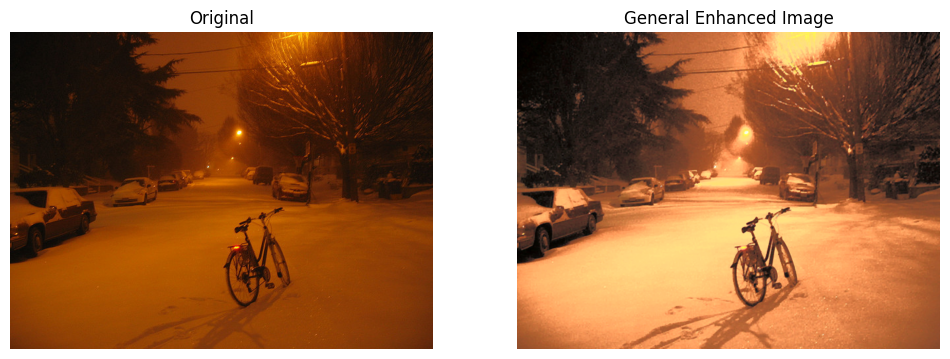

In [15]:
# Example usage
img_path = "assets/Image2.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

enh = general_enhance(img, upscale_factor=2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.title("General Enhanced Image")
plt.imshow(enh)
plt.axis('off')
plt.show()